# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product

import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob as glob
gsname = "gs0825"
L = []
for fp in glob('data/'+gsname+'/*'):
  df_ = pd.read_csv(fp)
  L.append(df_)
gsdf = pd.concat(L)
gsdf.to_csv('data/gsdf-'+gsname+'.csv')

In [3]:
gsdf.loc[:,'mi'] = gsdf.middle-gsdf.interleaved
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi
0,0,3.75,5000.0,8.0,1.160,2.0,1.0,1.0,1.0,0.506750,0.502750,0.506500,0.491000,0.500000,-0.011750
1,1,3.75,5000.0,10.0,1.160,2.0,1.0,1.0,1.0,0.486250,0.496750,0.502250,0.507500,0.509000,0.010750
0,0,10.25,5000.0,8.0,0.810,2.0,1.0,1.0,1.0,1.000000,0.930359,1.000000,1.000000,1.000000,0.069641
1,1,10.25,5000.0,10.0,0.810,2.0,1.0,1.0,1.0,1.000000,0.926372,1.000000,1.000000,1.000000,0.073628
0,0,0.01,5000.0,4.0,0.785,2.0,1.0,1.0,1.0,0.499875,0.494125,0.496500,0.498562,0.505187,0.004437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,37,3.71,3500.0,17.0,0.710,2.0,1.0,1.0,1.0,0.500250,0.498562,0.505500,0.512687,0.508750,0.014125
38,38,3.81,3500.0,17.0,0.710,2.0,1.0,1.0,1.0,0.496750,0.500250,0.499625,0.500687,0.498500,0.000437
39,39,3.91,3500.0,17.0,0.710,2.0,1.0,1.0,1.0,0.493375,0.495062,0.497062,0.508250,0.494562,0.013187
0,0,6.75,5000.0,8.0,0.360,2.0,1.0,1.0,1.0,1.000000,0.952377,1.000000,1.000000,1.000000,0.047623


In [4]:
gsdf.concentration.max()

12.25

In [5]:
D10 = gsdf.mi > 0.05
B50 = gsdf.blocked > 0.9
I = gsdf.interleaved < .65
df = gsdf[D10&B50&I].sort_values('mi',ascending=False)
df

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi
1,1,8.50,5000.0,10.0,0.785,2.0,1.0,1.0,1.0,1.0,0.482776,1.000000,0.700982,0.561462,0.218205
1,1,9.50,5000.0,10.0,1.060,2.0,1.0,1.0,1.0,1.0,0.539815,1.000000,0.752346,0.685105,0.212531
0,0,3.75,5000.0,8.0,0.260,2.0,1.0,1.0,1.0,1.0,0.571000,1.000000,0.752250,0.592250,0.181250
1,1,6.50,5000.0,10.0,0.460,2.0,1.0,1.0,1.0,1.0,0.584896,1.000000,0.749500,0.649250,0.164604
1,1,9.75,5000.0,10.0,1.160,2.0,1.0,1.0,1.0,1.0,0.494969,1.000000,0.655376,0.606565,0.160407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,12,1.21,5000.0,4.0,0.110,2.0,1.0,1.0,1.0,1.0,0.594812,0.992375,0.647000,0.668312,0.052188
23,23,2.31,5000.0,4.0,0.260,2.0,1.0,1.0,1.0,1.0,0.557437,1.000000,0.609375,0.553687,0.051938
0,0,2.00,5000.0,8.0,0.110,2.0,1.0,1.0,1.0,1.0,0.590000,1.000000,0.641250,0.717750,0.051250
21,21,2.11,3500.0,4.0,0.235,2.0,1.0,1.0,1.0,1.0,0.538250,1.000000,0.588938,0.588687,0.050688


Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

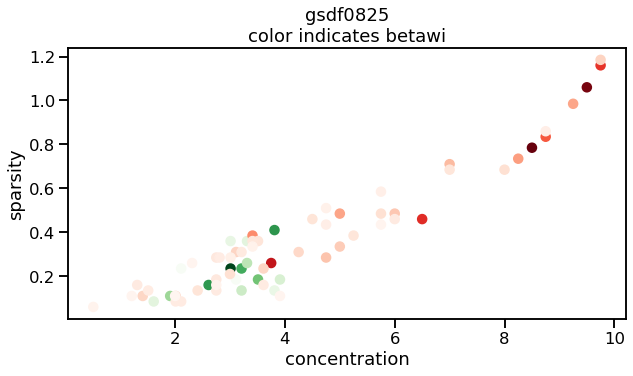

In [6]:
f,ax=plt.subplots(1,1,figsize=(10,5))

cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.sparsity,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

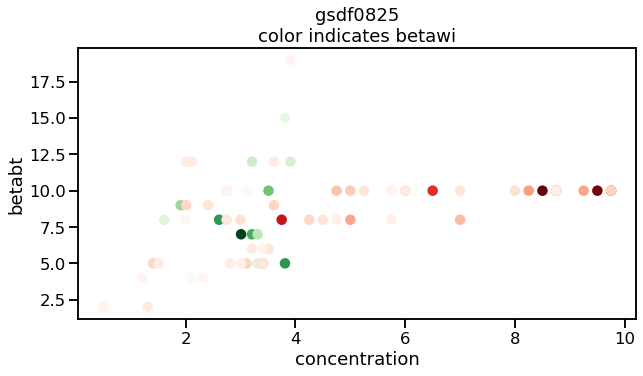

In [7]:
f,ax=plt.subplots(1,1,figsize=(10,5))

cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.stickiness_bt,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('betabt')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

In [8]:
assert False

AssertionError: 

In [ ]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [ ]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':1.4,
    'stickiness_wi':5000,
    'stickiness_bt':5, # 100
    'sparsity':0.08,
    'pvar': 2,
    'lrate':0.8,
    'lratep':1,
    'decay_rate':1,
} 
args = {
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str

In [ ]:
gridD = {
  'concentration': [1.4,2.0,2.2],
  'stickiness_wi': [5000],
  'stickiness_bt': [5,10],
  'sparsity': [0.08],
  'pvar': [2],
  'lrate': [1],
  'lratep': [1],
  'decay_rate': [0.99],
}

gridD
## grid
pnames = [i for i in gridD.keys()]
pranges = [i for i in gridD.values()]
for idx,i in enumerate(product(*pranges)):
  d = dict(zip(pnames,i))
  
print('number of param conditions',idx)
print(d)

In [ ]:
i,pnames
# dict(zip(pnames,i))

pvalstr = " ".join([str(j) for j in i])
out = "%s+%s"%(pnames,pvalstr)
out.split('+')[0]
pval

### main

In [ ]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [ ]:
ns = 5
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

In [ ]:
gsdf.to_csv('data/gsdf%i.csv'%tstamp)
gsdf ## test acc dataframe

In [ ]:
BI = gsdf.blocked > gsdf.interleaved
BM = gsdf.blocked > gsdf.middle
MI = gsdf.middle > gsdf.interleaved
gsdf[BI&BM&MI]